In [1]:
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import os


In [2]:
#Dataset
try:
    os.mkdir("dataset")
except Exception:
    print("Folder Exist")
    
!wget -c "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"  -P dataset
!ls dataset

Folder Exist
--2020-06-27 12:34:49--  https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving hub.jovian.ml (hub.jovian.ml)... 3.6.50.59
Connecting to hub.jovian.ml (hub.jovian.ml)|3.6.50.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

insurance.csv


In [3]:
df = pd.read_csv("dataset/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
# replacing categorical data with number 
# sex, smoker, region
df['sex'] = np.where(df['sex'].str.contains("female"),0,1) #0-female; 1-male
df['smoker'] = np.where(df['smoker'].str.contains("no"),0,1) # 0-no; 1-yes
df['region'] = np.where(df['region'].str.contains('northwest'),0,1) #0-northwest; 1-southwest

In [5]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,1,16884.92400
1,18,1,33.770,1,0,1,1725.55230
2,28,1,33.000,3,0,1,4449.46200
3,33,1,22.705,0,0,0,21984.47061
4,32,1,28.880,0,0,0,3866.85520


In [6]:
df.rename(columns={'sex':'is_male', 'smoker':'is_smoker', 'region':'from_southwest'}, inplace=True)
df.head()

,age,is_male,bmi,children,is_smoker,from_southwest,charges
0,19,0,27.900,0,1,1,16884.92400
1,18,1,33.770,1,0,1,1725.55230
2,28,1,33.000,3,0,1,4449.46200
3,33,1,22.705,0,0,0,21984.47061
4,32,1,28.880,0,0,0,3866.85520


In [7]:
# create dataset 
inputs = df.iloc[:,:-1]
target = df.iloc[:,-1]
#target.head()

In [8]:
inputs = np.array(inputs, dtype=np.float32)
inputs = torch.from_numpy(inputs)

target = np.array(target, dtype=np.float32)
target = torch.from_numpy(target)
target = target.reshape(1338,1)  # important
 
dataset = TensorDataset(inputs, target)
target.shape

torch.Size([1338, 1])

In [9]:
train_ds, val_ds = random_split(dataset, [1000, 338])

In [10]:
batch_size = 8
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)

In [11]:
for xb, yb in val_dl:
    print(xb,"\n", yb)
    break;

tensor([[59.0000,  1.0000, 37.1000,  1.0000,  0.0000,  1.0000],
        [30.0000,  0.0000, 33.3300,  1.0000,  0.0000,  1.0000],
        [44.0000,  0.0000, 25.8000,  1.0000,  0.0000,  1.0000],
        [49.0000,  1.0000, 35.8600,  0.0000,  0.0000,  1.0000],
        [56.0000,  1.0000, 39.6000,  0.0000,  0.0000,  1.0000],
        [27.0000,  0.0000, 36.0800,  0.0000,  1.0000,  1.0000],
        [28.0000,  1.0000, 37.1000,  1.0000,  0.0000,  1.0000],
        [61.0000,  0.0000, 31.1600,  0.0000,  0.0000,  0.0000]]) 
 tensor([[12347.1719],
        [ 4151.0288],
        [ 7624.6299],
        [ 8124.4082],
        [10601.4121],
        [37133.8984],
        [ 3277.1609],
        [13429.0352]])


In [12]:
class InsuranceModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(6, 1)
    
    def forward(self, xb):
        out = self.linear1(xb)
        return out
       
    def training_step(self,batch):
        xb, yb = batch
        out = self(xb)
        loss = F.l1_loss(out, yb)
        return loss
    
    def validation_step(self,batch):
        xb, yb = batch
        out = self(xb)
        loss = F.l1_loss(out, yb)
        return {"val_batch_loss": loss.detach()}
    
    def validation_epoch_end(self, val_outputs):
        batch_losses = [x['val_batch_loss'] for x in val_outputs]
        epoch_loss = torch.tensor(batch_losses).mean()
        #epoch_loss = torch.stack(batch_losses).mean()
        return {"val_loss":epoch_loss.item()}
   
    def epoch_end(self, epoch, result, num_epochs):
        if (epoch + 1) % (num_epochs / 10) == 0:
            print("Epoch: {:4d} \t val_loss:{:4f}".format(epoch+1, result['val_loss']))
    
        

In [13]:

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(num_epochs, lr, model:InsuranceModel, train_dl, val_dl, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(num_epochs):
        # Training phase
        for batch in train_dl:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # validation phase
        
        result = evaluate(model, val_dl)
        model.epoch_end(epoch, result, num_epochs)
        history.append(result)
    return history

In [14]:
model = InsuranceModel()

In [15]:
evaluate(model, val_dl)

{'val_loss': 13989.994140625}

In [16]:
h1 = fit(9000, .1, model, train_dl, val_dl)

Epoch:  900 	 val_loss:6922.193359
Epoch: 1800 	 val_loss:6415.747070
Epoch: 2700 	 val_loss:5916.836914
Epoch: 3600 	 val_loss:5478.388672
Epoch: 4500 	 val_loss:4988.088867
Epoch: 5400 	 val_loss:4668.265625
Epoch: 6300 	 val_loss:4510.737305
Epoch: 7200 	 val_loss:4437.516113
Epoch: 8100 	 val_loss:4401.196289
Epoch: 9000 	 val_loss:4407.456543


In [17]:
[*model.parameters()]

[Parameter containing:
 tensor([[ 2.6509e+02, -4.5771e+02,  1.2916e+01,  3.6436e+02,  1.6225e+04,
          -1.3984e+02]], requires_grad=True),
 Parameter containing:
 tensor([-3545.5488], requires_grad=True)]

In [18]:
preds = model(inputs)
preds

tensor([[17936.4395],
        [ 1429.0979],
        [ 4798.7964],
        ...,
        [ 1562.2303],
        [ 2214.7783],
        [29225.2266]], grad_fn=<AddmmBackward>)

In [19]:
target

tensor([[16884.9238],
        [ 1725.5522],
        [ 4449.4619],
        ...,
        [ 1629.8335],
        [ 2007.9449],
        [29141.3594]])

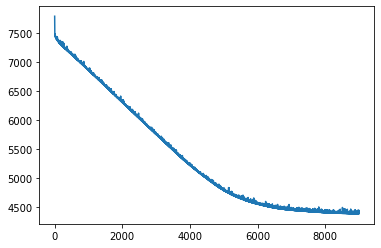

In [22]:
plt.plot([x['val_loss'] for x in h1])